# Оптимизация признакового пространства (Feature space optimization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Подключение библиотек 

In [22]:
# отключаем вывод предупреждений
import warnings
warnings.filterwarnings('ignore')

In [24]:
# подключение библиотек
from numpy import mean
from numpy import std
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification


In [25]:
n_inform = 5

In [26]:
# генерация набора данных
X, y = make_classification(n_samples=100, n_features=12, n_informative=n_inform, random_state=5, n_classes=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
# Функция для сравнения методов
def get_score(model, X, y, X_val, y_val):
  model.fit(X, y)
  y_pred = model.predict_proba(X_val)[:,1]
  score = roc_auc_score(y_val, y_pred)
  return score

SEED = 144

logit = LogisticRegression(random_state = SEED)
rf = RandomForestClassifier(random_state = SEED)

In [28]:
baseline_logit_score = get_score(logit, X_train, y_train, X_test, y_test)
print('Logistic Regression score:', baseline_logit_score)

Logistic Regression score: 0.8376623376623377


In [29]:
baseline_rf_score = get_score(rf, X_train, y_train, X_test, y_test)
print('Random Forest score:', baseline_rf_score)

Random Forest score: 0.8798701298701299


## Отбор информативных признаков

### Методы фильтрации (filter methods)

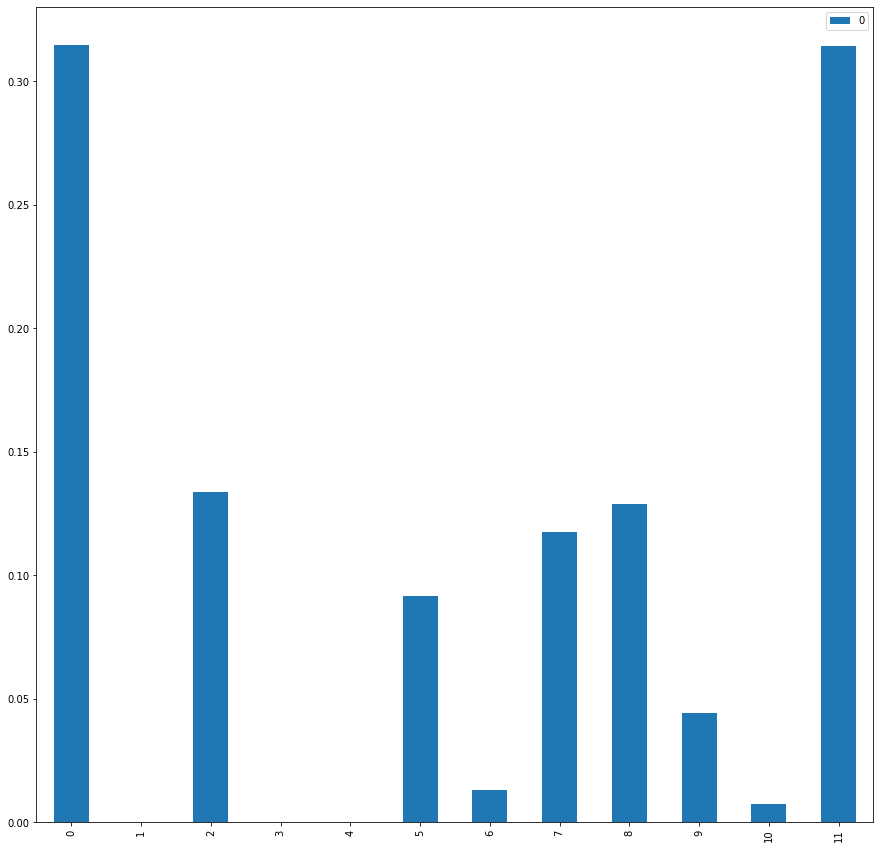

In [30]:
mutual_info = SelectKBest(mutual_info_classif, k = n_inform)

mi = mutual_info.fit(X_train,y_train)
imp = pd.DataFrame(mi.scores_)
imp.plot.bar(figsize=(15,15))


In [31]:
X_train_mi = mutual_info.fit_transform(X_train, y_train)
X_train_mi = pd.DataFrame(X_train_mi, columns = list(pd.DataFrame(X_train).columns[mutual_info.get_support()]))

X_val_mi = mutual_info.transform(X_test)

In [33]:
mi_logit_score = get_score(logit, X_train_mi, y_train, X_val_mi, y_test)
print('Logistic Regression score:', mi_logit_score)

Logistic Regression score: 0.8831168831168832


In [34]:
mi_rf_score = get_score(rf, X_train_mi, y_train, X_val_mi, y_test)
print('Random Forest score:', mi_rf_score)

Random Forest score: 0.9188311688311688


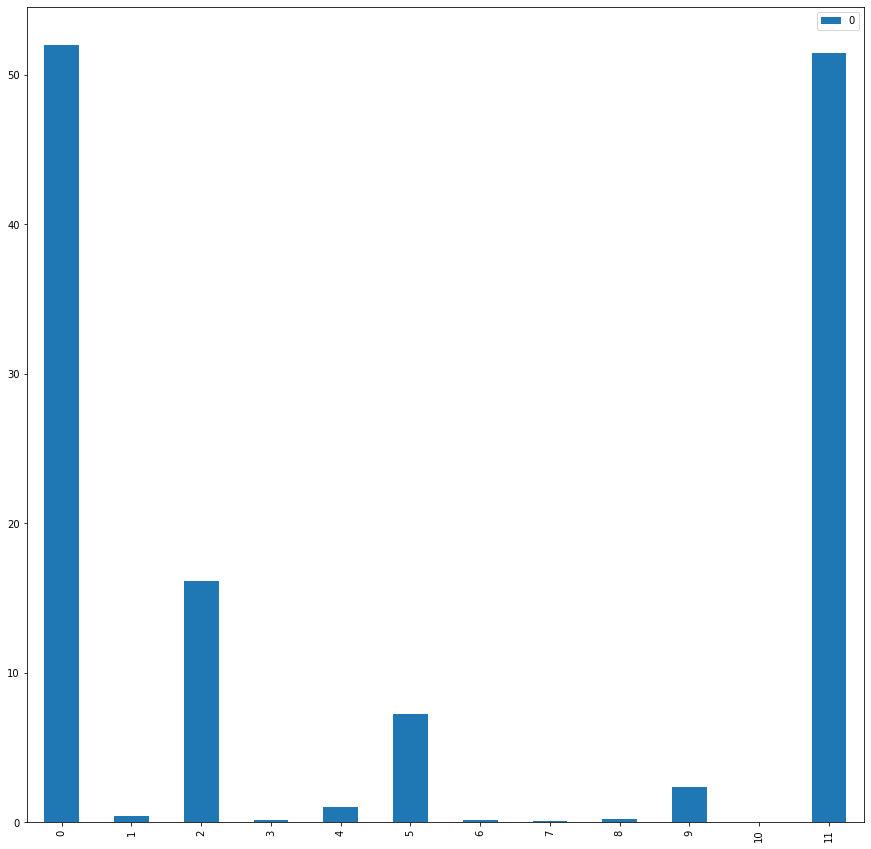

In [35]:
anova = SelectKBest(f_classif, k=n_inform)

an = anova.fit(X_train,y_train)
imp = pd.DataFrame(an.scores_)
imp.plot.bar(figsize=(15,15))

In [36]:
X_train_an = anova.fit_transform(X_train, y_train)
X_train_an = pd.DataFrame(X_train_an, columns = list(pd.DataFrame(X_train).columns[anova.get_support()]))

X_val_an = anova.transform(X_test)

In [37]:
an_logit_score = get_score(logit, X_train_an, y_train, X_val_an, y_test)
print('Logistic Regression score:', an_logit_score)

Logistic Regression score: 0.8831168831168831


In [38]:
an_rf_score = get_score(rf, X_train_mi, y_train, X_val_mi, y_test)
print('Random Forest score:', an_rf_score)

Random Forest score: 0.9188311688311688


### Методы обертки (wrapper methods)

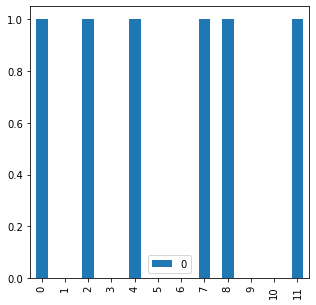

In [39]:

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
 
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

ffs = SequentialFeatureSelector(lr) 
ffs.fit(X_train, y_train)

features = ffs.get_support()

imp = pd.DataFrame(1*features)
imp.plot.bar(figsize=(5,5))


In [40]:
X_train_ffs = ffs.fit_transform(X_train, y_train)
X_train_ffs = pd.DataFrame(X_train_ffs, columns = list(pd.DataFrame(X_train).columns[ffs.get_support()]))

X_val_ffs = ffs.transform(X_test)

In [41]:
ffs_logit_score = get_score(logit, X_train_ffs, y_train, X_val_ffs, y_test)
print('Logistic Regression score:', ffs_logit_score)

Logistic Regression score: 0.8896103896103895


In [42]:
ffs_rf_score = get_score(rf, X_train_ffs, y_train, X_val_ffs, y_test)
print('Random Forest score:', ffs_rf_score)

Random Forest score: 0.9448051948051948


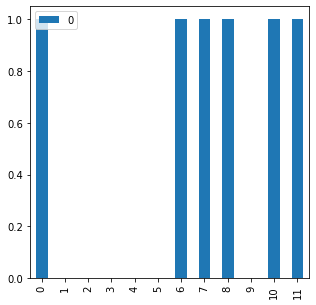

In [43]:
from sklearn.feature_selection import RFE

lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

rfe = RFE(lr)
rfe.fit(X_train, y_train)

features = rfe.get_support()

imp = pd.DataFrame(1*features)
imp.plot.bar(figsize=(5,5))

In [44]:
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_train_rfe = pd.DataFrame(X_train_rfe, columns = list(pd.DataFrame(X_train).columns[rfe.get_support()]))

X_val_rfe = rfe.transform(X_test)

In [45]:
rfe_logit_score = get_score(logit, X_train_rfe, y_train, X_val_rfe, y_test)
print('Logistic Regression score:', rfe_logit_score)

Logistic Regression score: 0.8571428571428572


In [46]:
rfe_rf_score = get_score(rf, X_train_rfe, y_train, X_val_rfe, y_test)
print('Random Forest score:', rfe_rf_score)

Random Forest score: 0.8961038961038961


### Встроенные методы (embedded methods)

In [49]:
from sklearn.feature_selection import SelectFromModel

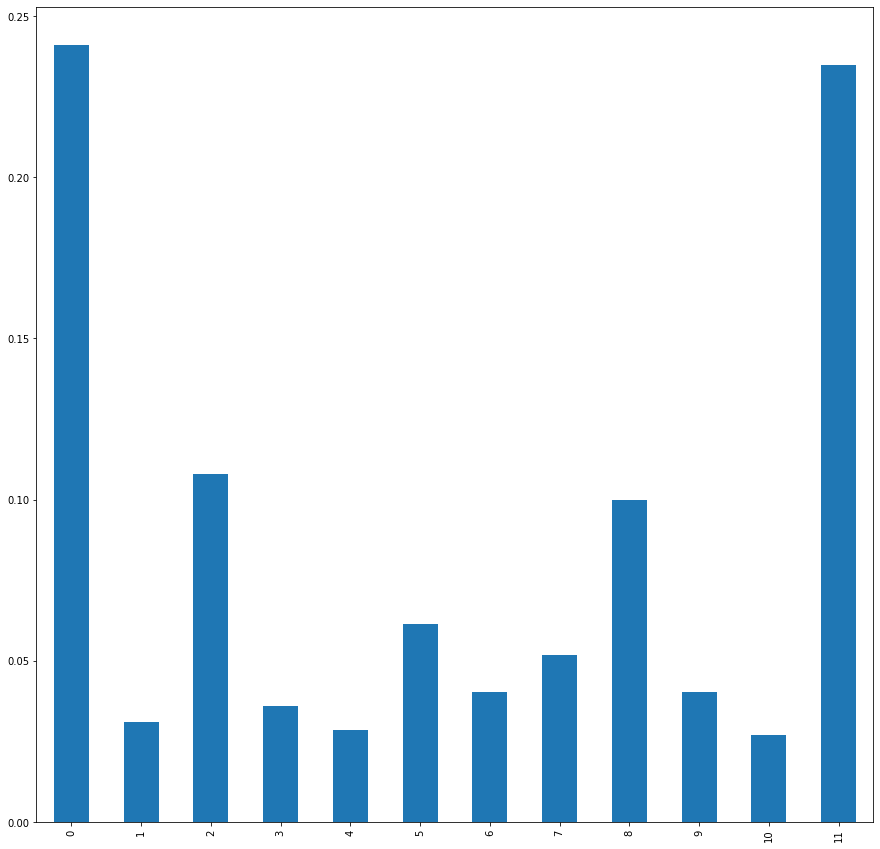

In [47]:
from sklearn.ensemble import RandomForestClassifier

# создаем случайное дерево с вашими гипер параметрами
rfc = RandomForestClassifier(n_estimators=340)

# Обучаем модель на вашей выборке; Где X, y - входные и выходные данные соответственно.
rfc.fit(X_train, y_train)

# Подбираем самые важные признаки
importances = rfc.feature_importances_

# Создаем отдельный датасет для визуализации
final_df = pd.DataFrame({"Features" : pd.DataFrame(X).columns, "Importances" : importances})
final_df['Importances'].plot.bar(figsize=(15,15))

In [51]:
model = SelectFromModel(rfc, prefit = True)

In [52]:
X_train_rf = model.transform(X_train)
X_val_rf = model.transform(X_test)

In [53]:
X_train_rf = pd.DataFrame(X_train_rf, columns = list(pd.DataFrame(X_train).columns[model.get_support()]))
X_val_rf = pd.DataFrame(X_val_rf, columns = list(pd.DataFrame(X_test).columns[model.get_support()]))

In [54]:
rf_logit_score = get_score(logit, X_train_rf, y_train, X_val_rf, y_test)
print('Logistic Regression score:', rf_logit_score)

Logistic Regression score: 0.8896103896103896


In [55]:
rf_rf_score = get_score(rf, X_train_rf, y_train, X_val_rf, y_test)
print('Random Forest score:', rf_rf_score)

Random Forest score: 0.8863636363636364


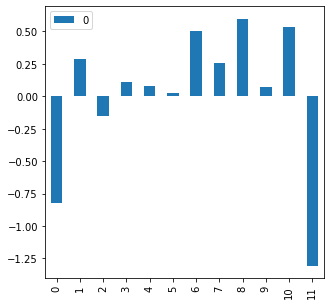

In [56]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(C = 1, penalty = "l2", dual = False).fit(X_train, y_train)

imp = pd.DataFrame(lsvc.coef_[0])
imp.plot.bar(figsize=(5,5))

In [57]:
model = SelectFromModel(lsvc, prefit = True)

In [58]:
X_train_lsvc = model.transform(X_train)
X_val_lsvc = model.transform(X_test)

In [59]:
X_train_lsvc = pd.DataFrame(X_train_lsvc, columns = list(pd.DataFrame(X_train).columns[model.get_support()]))
X_val_lsvc = pd.DataFrame(X_val_lsvc, columns = list(pd.DataFrame(X_test).columns[model.get_support()]))

In [60]:
lsvc_logit_score = get_score(logit, X_train_lsvc, y_train, X_val_lsvc, y_test)
print('Logistic Regression score with binary encoding:', lsvc_logit_score)

Logistic Regression score with binary encoding: 0.8831168831168832


In [61]:
lsvc_rf_score = get_score(rf, X_train_lsvc, y_train, X_val_lsvc, y_test)
print('Random Forest score:', lsvc_rf_score)

Random Forest score: 0.8636363636363636


## Снижение размерности (Dimensionality reduction)

### Стандартизация данных

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
scaler = StandardScaler() 
scaler.fit(X) 
X_scale = scaler.transform(X_train)
X_scale = pd.DataFrame(X_scale) 

X_val_scale = scaler.transform(X_test)
X_val_scale = pd.DataFrame(X_val_scale) 

### Метод главных компонент (principal component analysis)

In [65]:
from sklearn.decomposition import PCA

In [66]:
n_comp = n_inform
pca = PCA(n_components = n_comp) 
pca.fit(X_scale)

PCA(n_components=5)

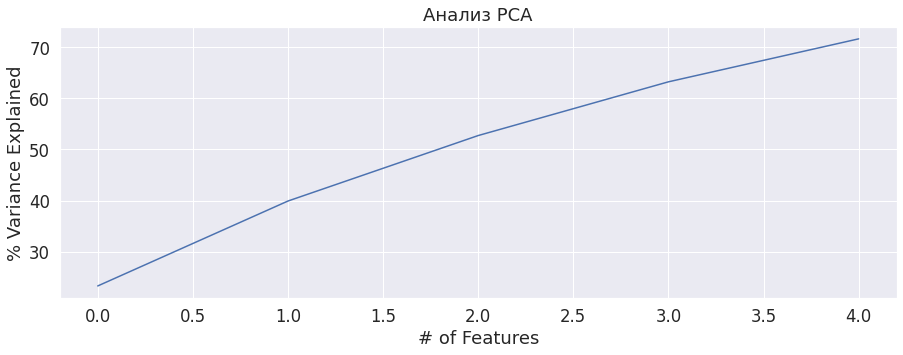

In [67]:
variance = pca.explained_variance_ratio_
var = np.cumsum (np.round (variance, 3) * 100) 

sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 5))
plt.ylabel('% Variance Explained') 
plt.xlabel('# of Features') 
plt.title('Анализ PCA') 
sns.lineplot(x = range(0, n_comp), y = var);

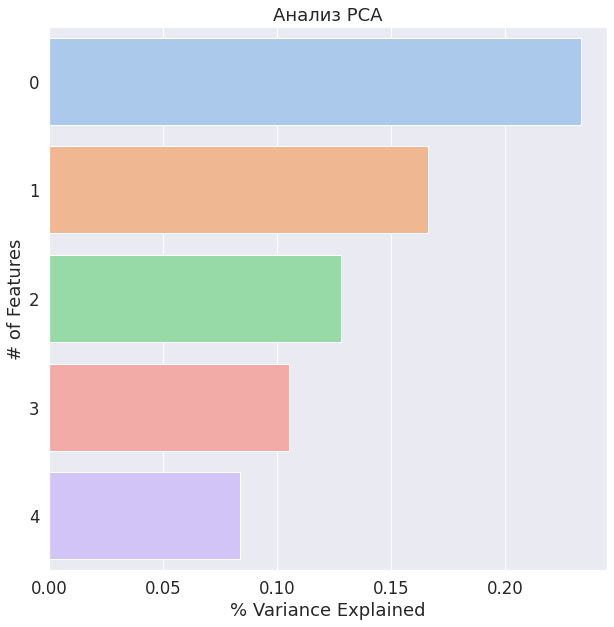

In [69]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(10, 10))
plt.ylabel('# of Features') 
plt.xlabel('% Variance Explained') 
plt.title('Анализ PCA') 
sns.barplot(y = list(range(0, n_comp)), x = pca.explained_variance_ratio_, palette = 'pastel', orient = 'h');

In [70]:
pca = PCA(n_components = 0.95, svd_solver = 'full') 
pca.fit(X_scale)

PCA(n_components=0.95, svd_solver='full')

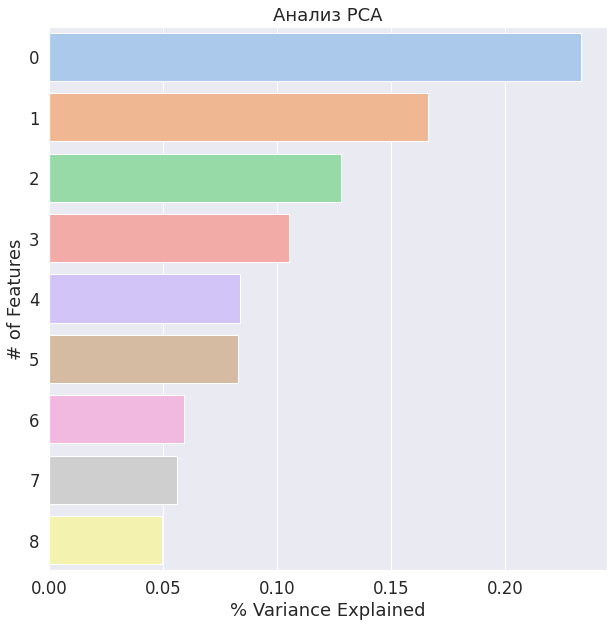

In [71]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(10, 10))
plt.ylabel('# of Features') 
plt.xlabel('% Variance Explained') 
plt.title('Анализ PCA') 
sns.barplot(y = list(range(0, pca.n_components_)), x = pca.explained_variance_ratio_, palette = 'pastel', orient = 'h');

In [72]:
X_train_pca = pca.transform(X_scale)
X_val_pca = pca.transform(X_val_scale)

In [73]:
X_pca = pd.DataFrame(X_train_pca, columns = [str(i) + ' component' for i in range(1, pca.n_components_ + 1)])
X_val_pca = pd.DataFrame(X_val_pca, columns = [str(i) + ' component' for i in range(1, pca.n_components_ + 1)])

In [74]:
pca_logit_score = get_score(logit, X_train_pca, y_train, X_val_pca, y_test)
print('Logistic Regression score:', pca_logit_score)

Logistic Regression score: 0.8896103896103895


In [75]:
pca_rf_score = get_score(rf, X_train_pca, y_train, X_val_pca, y_test)
print('Random Forest score:', pca_rf_score)

Random Forest score: 0.8376623376623376


### Стохастическое вложение соседей с t-распределением
### (t-distributed Stochastic Neighbor Embedding)

In [76]:
from sklearn.manifold import TSNE

In [77]:
X_train_tsne = TSNE(n_components = 2).fit_transform(X_scale)

In [78]:
X_train_tsne = pd.DataFrame(X_train_tsne)
X_train_tsne.rename(columns = {0:'1-я компонента', 1:'2-я компонента'}, inplace = True)
X_train_tsne["Class"] = y_train
X_train_tsne.head()

,1-я компонента,2-я компонента,Class
0,2.021442,1.759874,0
1,2.929665,2.809351,0
2,2.025657,-2.634868,1
3,2.463982,0.780786,0
4,5.071877,0.470729,0


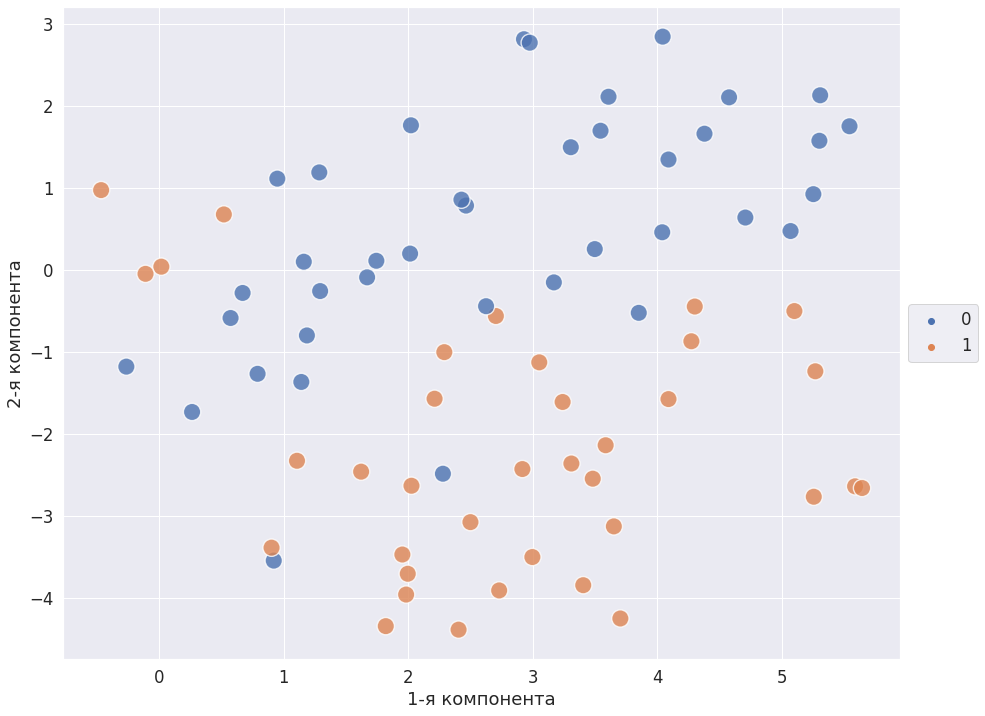

In [79]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 12))
g = sns.scatterplot(x = "1-я компонента", y = "2-я компонента", hue = "Class", data = X_train_tsne, s = 300, alpha = 0.8)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol = 1)

## Сравнение методов

In [80]:
score_logit = [baseline_logit_score, mi_logit_score, an_logit_score, ffs_logit_score, rfe_logit_score, rf_logit_score, lsvc_logit_score, pca_logit_score]

score_rf = [baseline_rf_score, mi_rf_score, an_rf_score, ffs_rf_score, rfe_rf_score, rf_rf_score, lsvc_rf_score, pca_rf_score]

methods = ['Baseline', 'Mutual information', 'ANOVA F-value', 'Sequential Feature Selection','Recursive feature elimination', 'Model Random Forest', 'Model linear SVM', 'PCA']

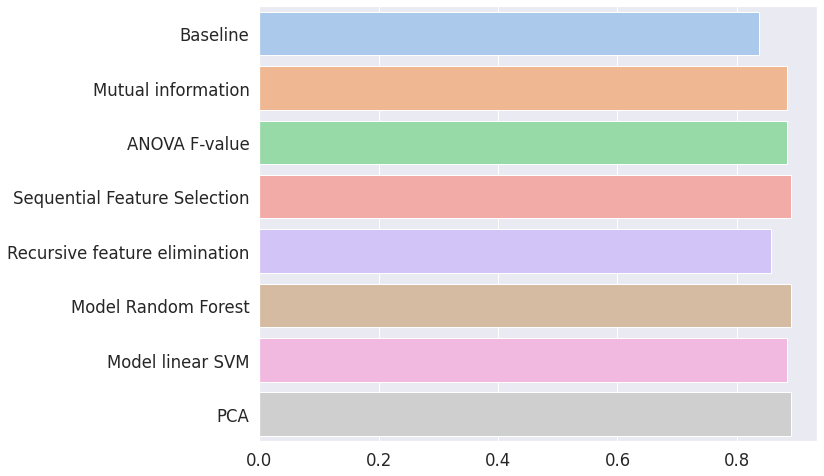

In [81]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(y = methods, x = score_logit, palette = 'pastel', orient = 'h');

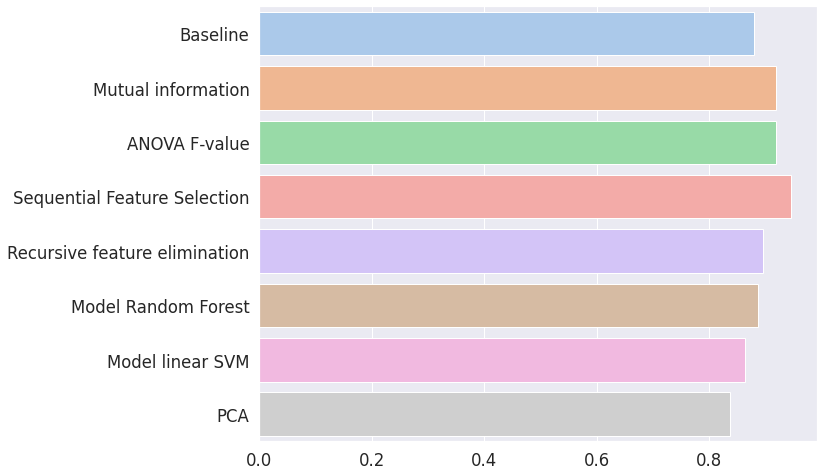

In [82]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(y = methods, x = score_rf, palette = 'pastel', orient = 'h');